In [55]:
import h5py
import xarray as xr
import numpy as np
import xgcm
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16

import warnings
warnings.filterwarnings('ignore', '.*FutureWarning*.')
warnings.filterwarnings('ignore', '.*.')

div_cmap = plt.get_cmap('RdBu_r')
div_cmap.set_bad(color=(0.8,0.8,0.8))

cmap = plt.get_cmap('viridis')
cmap.set_bad(color=(0.8,0.8,0.8))

In [56]:
nIter = 1
step0 = 7200
nstep = step0*2

iters = range(step0,nIter*nstep+step0,nstep)
print(list(iters))

[7200]


In [57]:
data_dir = "../../MITgcm/experiments/rotated/run/"

#ds = open_mdsdataset(data_dir,iters=[252000],ignore_unknown_vars=True,prefix=["snapDiag"])
ds = open_mdsdataset(data_dir,iters=[259200],ignore_unknown_vars=True,prefix=["standardDiag"])
#ds = open_mdsdataset(data_dir,iters=[259200],ignore_unknown_vars=True,prefix=["standardDiag"])

ds['time'] = ds['time']*60 # convert from iterations to seconds
grid = xgcm.Grid(ds, periodic=['X','Y'])

coords = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)
coords['dV'] = coords['rA']*(coords['drF']*coords['hFacC'])

H = coords['Depth'].max()
ds['Z'].values = ds['Z'].values + H.values
ds['Zl'].values = ds['Zl'].values + H.values

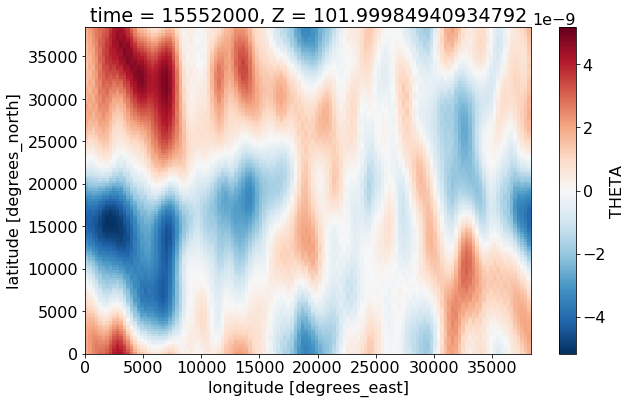

In [54]:
var = 'THETA'
q = (ds[var].sel(Z=100, method='nearest').isel(time=0) - ds[var].sel(Z=100, method='nearest').isel(time=0).mean(dim=['YC'])).plot()
#plt.ylim([0,200])
#q.set_clim([-1.e-10,1.e-10])

In [ ]:
nIter*180.*60.

NameError: name 't' is not defined

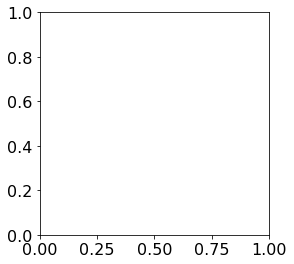

In [108]:
slice_time = nIter*180.*60.

ylim = [0., 300.]
tlim = [0, slice_time]

plt.figure(figsize=(14,9))

plt.subplot(2,3,1)
plt.pcolormesh(t, z, b*1.e4, cmap=div_cmap)
plt.colorbar(label='buoyancy [10$^{-4}$ m/s$^{2}$]')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim(tlim)
plt.clim([-2.,2.])
plt.xlabel('time [days]')
plt.xticks([0,25*86400., 50*86400.], [0, 25, 50])

plt.subplot(2,3,2)
g = 9.81; tAlpha = 2.e-4
ds['b'] = ds['THETA']*(g*tAlpha)
q = (ds['b'].mean(dim=['XC','YC'])*1.e4).plot(y='Z')
q.set_clim([-2.,2.])
q.colorbar.set_label('buoyancy [10$^{-4}$ m/s$^{2}$]')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim(tlim)
plt.xlabel('time [days]')
plt.xticks([0,25*86400., 50*86400.], [0, 25, 50])

plt.subplot(2,3,3)
ds_hills['b'] = ds_hills['THETA']*(g*tAlpha)

plt.plot(
    ds['b'].isel(time=np.argmin(np.abs(ds['time']-slice_time))).mean(dim=['XC','YC']).values*1.e4,
    ds['Z'],
    label='MITgcm')

plt.plot(b[:,[np.argmin(np.abs(t-slice_time))]]*1.e4, z, "--", label='dedalus')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim([-2.,2.])
plt.xlabel(r'buoyancy [10$^{-4}$ m/s$^{2}$]')
plt.legend()

plt.subplot(2,3,4)
plt.pcolormesh(t, z, v*100., cmap=div_cmap)
plt.colorbar(label='along-slope velocity [cm/s]')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim(tlim)
plt.clim([-1.,1.])
plt.xlabel('time [days]')
plt.xticks([0,25*86400., 50*86400.], [0, 25, 50])

plt.subplot(2,3,5)
q = (ds['VVEL'].mean(dim=['XC','YG'])*100.).plot(y='Z')
q.set_clim([-1.,1.])
q.colorbar.set_label('along-slope velocity [cm/s]')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim(tlim)
plt.xlabel('time [days]')
plt.xticks([0,25*86400., 50*86400.], [0, 25, 50])


plt.subplot(2,3,6)
plt.plot(
    ds['VVEL'].isel(time=np.argmin(np.abs(ds['time']-slice_time))).mean(dim=['XC','YG']).values*100.,
    ds['Z'],
    label='MITgcm')

plt.plot(v[:,[np.argmin(np.abs(t-slice_time))]]*100., z, "--", label='dedalus')
plt.ylim(ylim)
plt.ylabel('hab [m]')
plt.xlim([-1.,1.])
plt.xlabel('along-slope velocity [cm/s]')

plt.tight_layout()
plt.savefig("../../figures/bbl_compare_dedalus.png", dpi=100, bbox_inches='tight')

In [8]:
θ = 2.e-3
Γ = 0.0008613

ds['Zr'] = ds['Z']*np.cos(θ) + ds['XC']*np.sin(θ)
ds['Xr'] = ds['XC']*np.cos(θ) - ds['Z']*np.sin(θ)

ds['THETA'] = ds['THETA'].where(ds['THETA'].isel(time=0) != 0.)
ds['THETA_BG'] = ds['THETA'] + ds['Zr'] * Γ


ds_hills['Zr'] = ds_hills['Z']*np.cos(θ) + ds_hills['XC']*np.sin(θ)
ds_hills['Xr'] = ds_hills['XC']*np.cos(θ) - ds_hills['Z']*np.sin(θ)

ds_hills['THETA'] = ds_hills['THETA'].where(ds_hills['THETA'].isel(time=0) != 0.)
ds_hills['THETA_BG'] = ds_hills['THETA'] + ds_hills['Zr'] * Γ

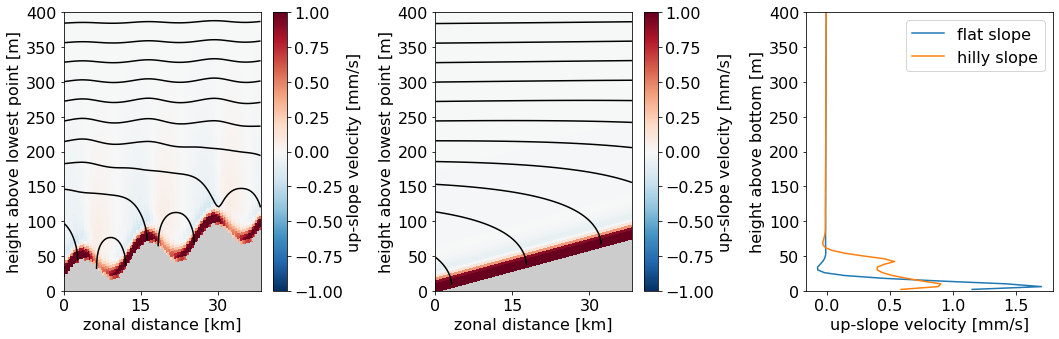

In [9]:
ulim = [-1., 1.]

ds['UVEL'] = ds['UVEL'].where(ds['UVEL'].isel(time=0) != 0.)
ds_hills['UVEL'] = ds_hills['UVEL'].where(ds_hills['UVEL'].isel(time=0) != 0.)

plt.figure(figsize=(15, 5))
ax = plt.subplot(1,3,1, facecolor=(.8, .8, .8))
plt.pcolormesh(ds_hills['Xr'].values.swapaxes(0,1), ds_hills['Zr'].values, ds_hills['UVEL'].isel(YC=64, time=-1)*1e3, cmap='RdBu_r')
plt.clim(ulim)
plt.colorbar(label='up-slope velocity [mm/s]')
plt.contour(ds_hills['Xr'].values.swapaxes(0,1), ds_hills['Zr'].values, ds_hills['THETA_BG'].isel(YC=64, time=-1), colors='k', levels=np.arange(0.,2., 0.025))
plt.ylim([0,400])
plt.ylabel('height above lowest point [m]')
plt.xticks([0,1.5e4,3.0e4], [0, 15, 30])
plt.xlabel('zonal distance [km]')

plt.subplot(1,3,2, facecolor=(.8, .8, .8))
plt.pcolormesh(ds['Xr'].values.swapaxes(0,1), ds_hills['Zr'].values, ds['UVEL'].isel(YC=64, time=-1)*1e3, cmap='RdBu_r')
plt.clim(ulim)
plt.colorbar(label='up-slope velocity [mm/s]')
plt.contour(ds_hills['Xr'].values.swapaxes(0,1), ds_hills['Zr'].values, ds['THETA_BG'].isel(YC=64, time=-1), colors='k', levels=np.arange(0.,2., 0.025))
plt.ylim([0,400])
plt.ylabel('height above lowest point [m]')
plt.xticks([0,1.5e4,3.0e4], [0, 15, 30])
plt.xlabel('zonal distance [km]')

plt.subplot(1,3,3)
plt.plot(
    ds['UVEL'].isel(time=-1).mean(dim=['XG','YC'], skipna=True).values*1e3,
    ds['Z'],
    label='flat slope')

plt.plot(
    ds_hills['UVEL'].isel(time=-1).mean(dim=['XG','YC'], skipna=True).values*1e3,
    ds_hills['Z'],
    label='hilly slope')
plt.ylim([0,400])
plt.ylabel('height above bottom [m]')
plt.legend()
plt.xlabel('up-slope velocity [mm/s]')

plt.tight_layout()

plt.savefig("../../figures/bbl_hills_spinup.png", dpi=100, bbox_inches='tight')

# See floating axes demo

https://stackoverflow.com/questions/52191695/rotate-transformation-on-matplotlib-axis-in-subplot

https://matplotlib.org/gallery/axisartist/demo_floating_axes.html

https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html